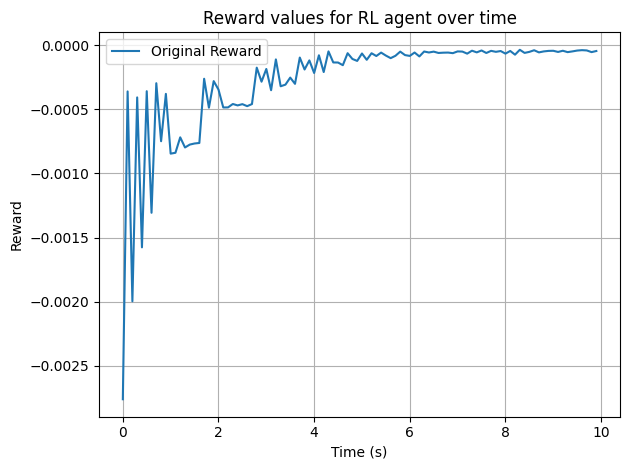

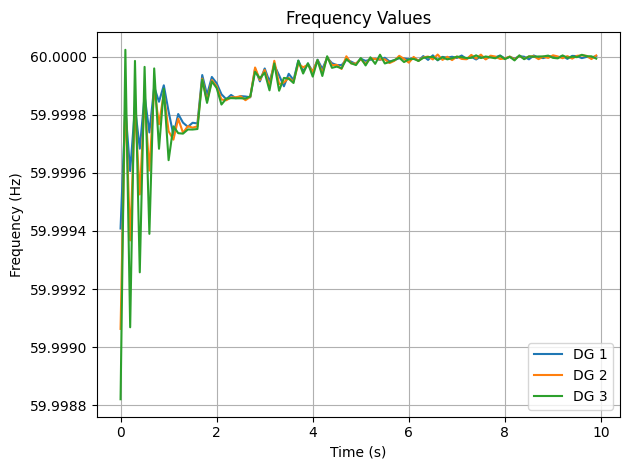

In [ ]:
# Implementation 1

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List
from  matplotlib.ticker import ScalarFormatter
# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for backup_dg_num in range(N_BACKUP_DG):
        shared_data[N_DG + backup_dg_num]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

recorded_states = []

actual_reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    # Centralized DQN agent decides the control mode for all DGs
    action = agent.act(state)
    reconstruct = bool(action) # boolean for action

    total_reward = 0

    for dg in DGs:

        delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        shared_data[dg.index]['f'] = dg.f
        shared_data[dg.index]['V_mag'] = dg.V_mag
        shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

    actual_reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    agent.remember(state, action, total_reward, next_state, done)
    agent.replay()

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))


# plt.figure(figsize=(5, 5))
plt.plot(t, actual_reward_history, label='Original Reward')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent over time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("True_Reward.png")
plt.show()

plt.figure()
plt.plot(t, f_history.T)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values')
plt.legend([f'DG {i + 1}' for i in range(N_DG)])
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.tight_layout()
plt.grid()
plt.savefig("true_freq.png")

# plt.figure()
# plt.plot(t, V_history)
# plt.xlabel('Time (s)')
# plt.ylabel('Voltage')
# plt.title('Volatge Values')
# plt.legend([f'DG {i + 1}' for i in range(N_DG)])
# plt.grid()
# plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))


# When there is perturbation in the environment, and adversary change the value of voltage and frequency in the environment.

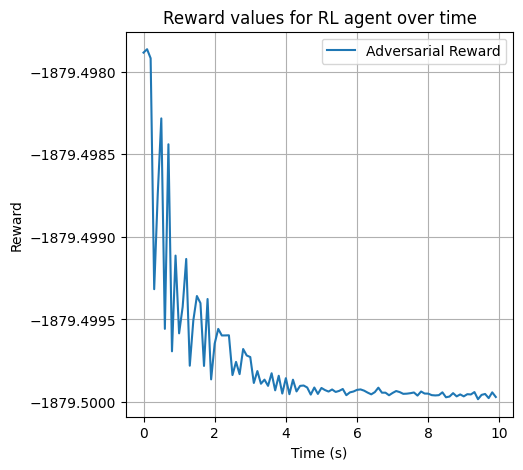

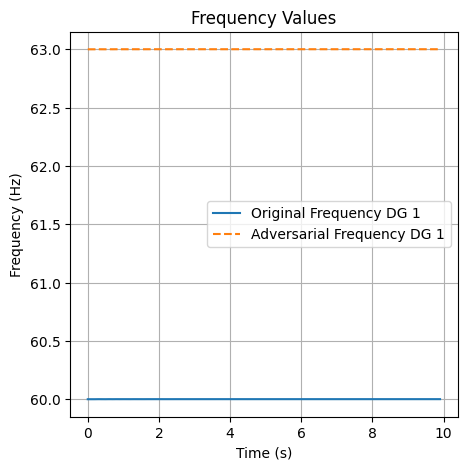

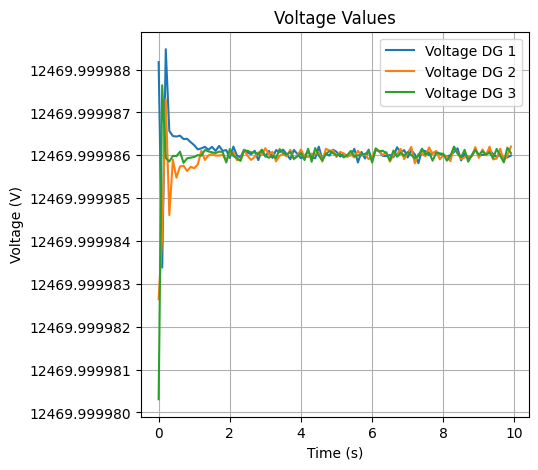

Average Deviation: 1879.4994902600833
Performance Degradation (RD): 1879.4994902600831
FD=[2.99993368 2.99992471 2.99992461]
VD=[623.49998539 623.49998524 623.49998528]
AD=3
System Stability Index (SSI): 656.499912971234


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List
from matplotlib.ticker import ScalarFormatter
# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for i in range(N_BACKUP_DG):
        shared_data[N_DG + i]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

recorded_states = []

reward_history = np.zeros(len(t))
manipulated_reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

original_f_values = np.zeros((N_DG, len(t)))
manipulated_f_values = np.zeros((N_DG, len(t)))
original_v_values = np.zeros((N_DG, len(t), 3))
manipulated_v_values = np.zeros((N_DG, len(t), 3))

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    # Centralized DQN agent decides the control mode for all DGs
    action = agent.act(state)
    reconstruct = bool(action) # boolean for action

    total_reward = 0
    manipulated_reward = 0

    for dg in DGs:
        delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        shared_data[dg.index]['f'] = dg.f
        shared_data[dg.index]['V_mag'] = dg.V_mag
        shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        # Record original values
        original_f_values[dg.index, i] = dg.f
        original_v_values[dg.index, i] = dg.V_mag

        # Apply adversarial manipulation
        # manipulated_f = dg.f * (1 + np.random.uniform(-0.05, 0.05))
        manipulated_f = dg.f * (1 + 0.05)
        # manipulated_f = dg.f * (1 )
        # manipulated_v = dg.V_mag * (1 + np.random.uniform(-0.05, 0.05, size=3))
        manipulated_v = dg.V_mag * (1 + 0.05)
        # manipulated_v = dg.V_mag * (1 )

        # Record manipulated values
        manipulated_f_values[dg.index, i] = manipulated_f
        manipulated_v_values[dg.index, i] = manipulated_v

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

        manipulated_reward = -abs((f_ref - manipulated_f) + (V_nom_mag - manipulated_v[0]))
        manipulated_reward_history[i] += manipulated_reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    agent.remember(state, action, total_reward, next_state, done)
    agent.replay()

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))

# Plotting the rewards
plt.figure(figsize=(5, 5))
# plt.plot(t, reward_history, label='Original Reward')
plt.plot(t, manipulated_reward_history, label='Adversarial Reward')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent over time')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()

# Plotting the frequency values
plt.figure(figsize=(5, 5))
for i in range(1):
    plt.plot(t, original_f_values[i], label=f'Original Frequency DG {i+1}')
    plt.plot(t, manipulated_f_values[i], '--', label=f'Adversarial Frequency DG {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values')
plt.legend()
plt.grid()
plt.show()

# Plotting the voltage values
plt.figure(figsize=(5, 5))
for i in range(3):
    plt.plot(t, original_v_values[i, :, 0], label=f'Voltage DG {i+1}')
    # plt.plot(t, manipulated_v_values[i, :, 0], '--', label=f'Adversarial Voltage DG {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage Values')
plt.legend()
plt.grid()
# Use ScalarFormatter for the y-axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.show()


# Calculate System Stability Index (SSI) components
def calculate_FD(f_values, f_ref):
    return np.mean(np.abs(f_values - f_ref), axis=1)

def calculate_VD(v_values, V_nom_mag):
    return np.mean(np.abs(v_values - V_nom_mag), axis=(1, 2))

def calculate_AD(f_values, v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v):
    count_affected_dgs = 0
    for i in range(N_DG):
        if np.mean(np.abs((f_values[i]) - f_ref)) > epsilon_f or np.mean(np.abs((v_values[i]) - V_nom_mag)) > epsilon_v:
            count_affected_dgs += 1
    return count_affected_dgs
# Parameters for SSI
alpha, beta, gamma = 1, 1, 10  # example weights
epsilon_f = 0.05  # example threshold for frequency deviation
epsilon_v = 10  # example threshold for voltage deviation


average_deviation = np.mean(np.abs(reward_history - manipulated_reward_history))
print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.abs(np.mean(reward_history) - np.mean(manipulated_reward_history))
print(f"Performance Degradation (RD): {performance_degradation}")

# Calculate SSI components
FD = calculate_FD(manipulated_f_values, f_ref)
VD = calculate_VD(manipulated_v_values, V_nom_mag)
AD = calculate_AD(manipulated_f_values, manipulated_v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f"System Stability Index (SSI): {SSI}")


Combined results

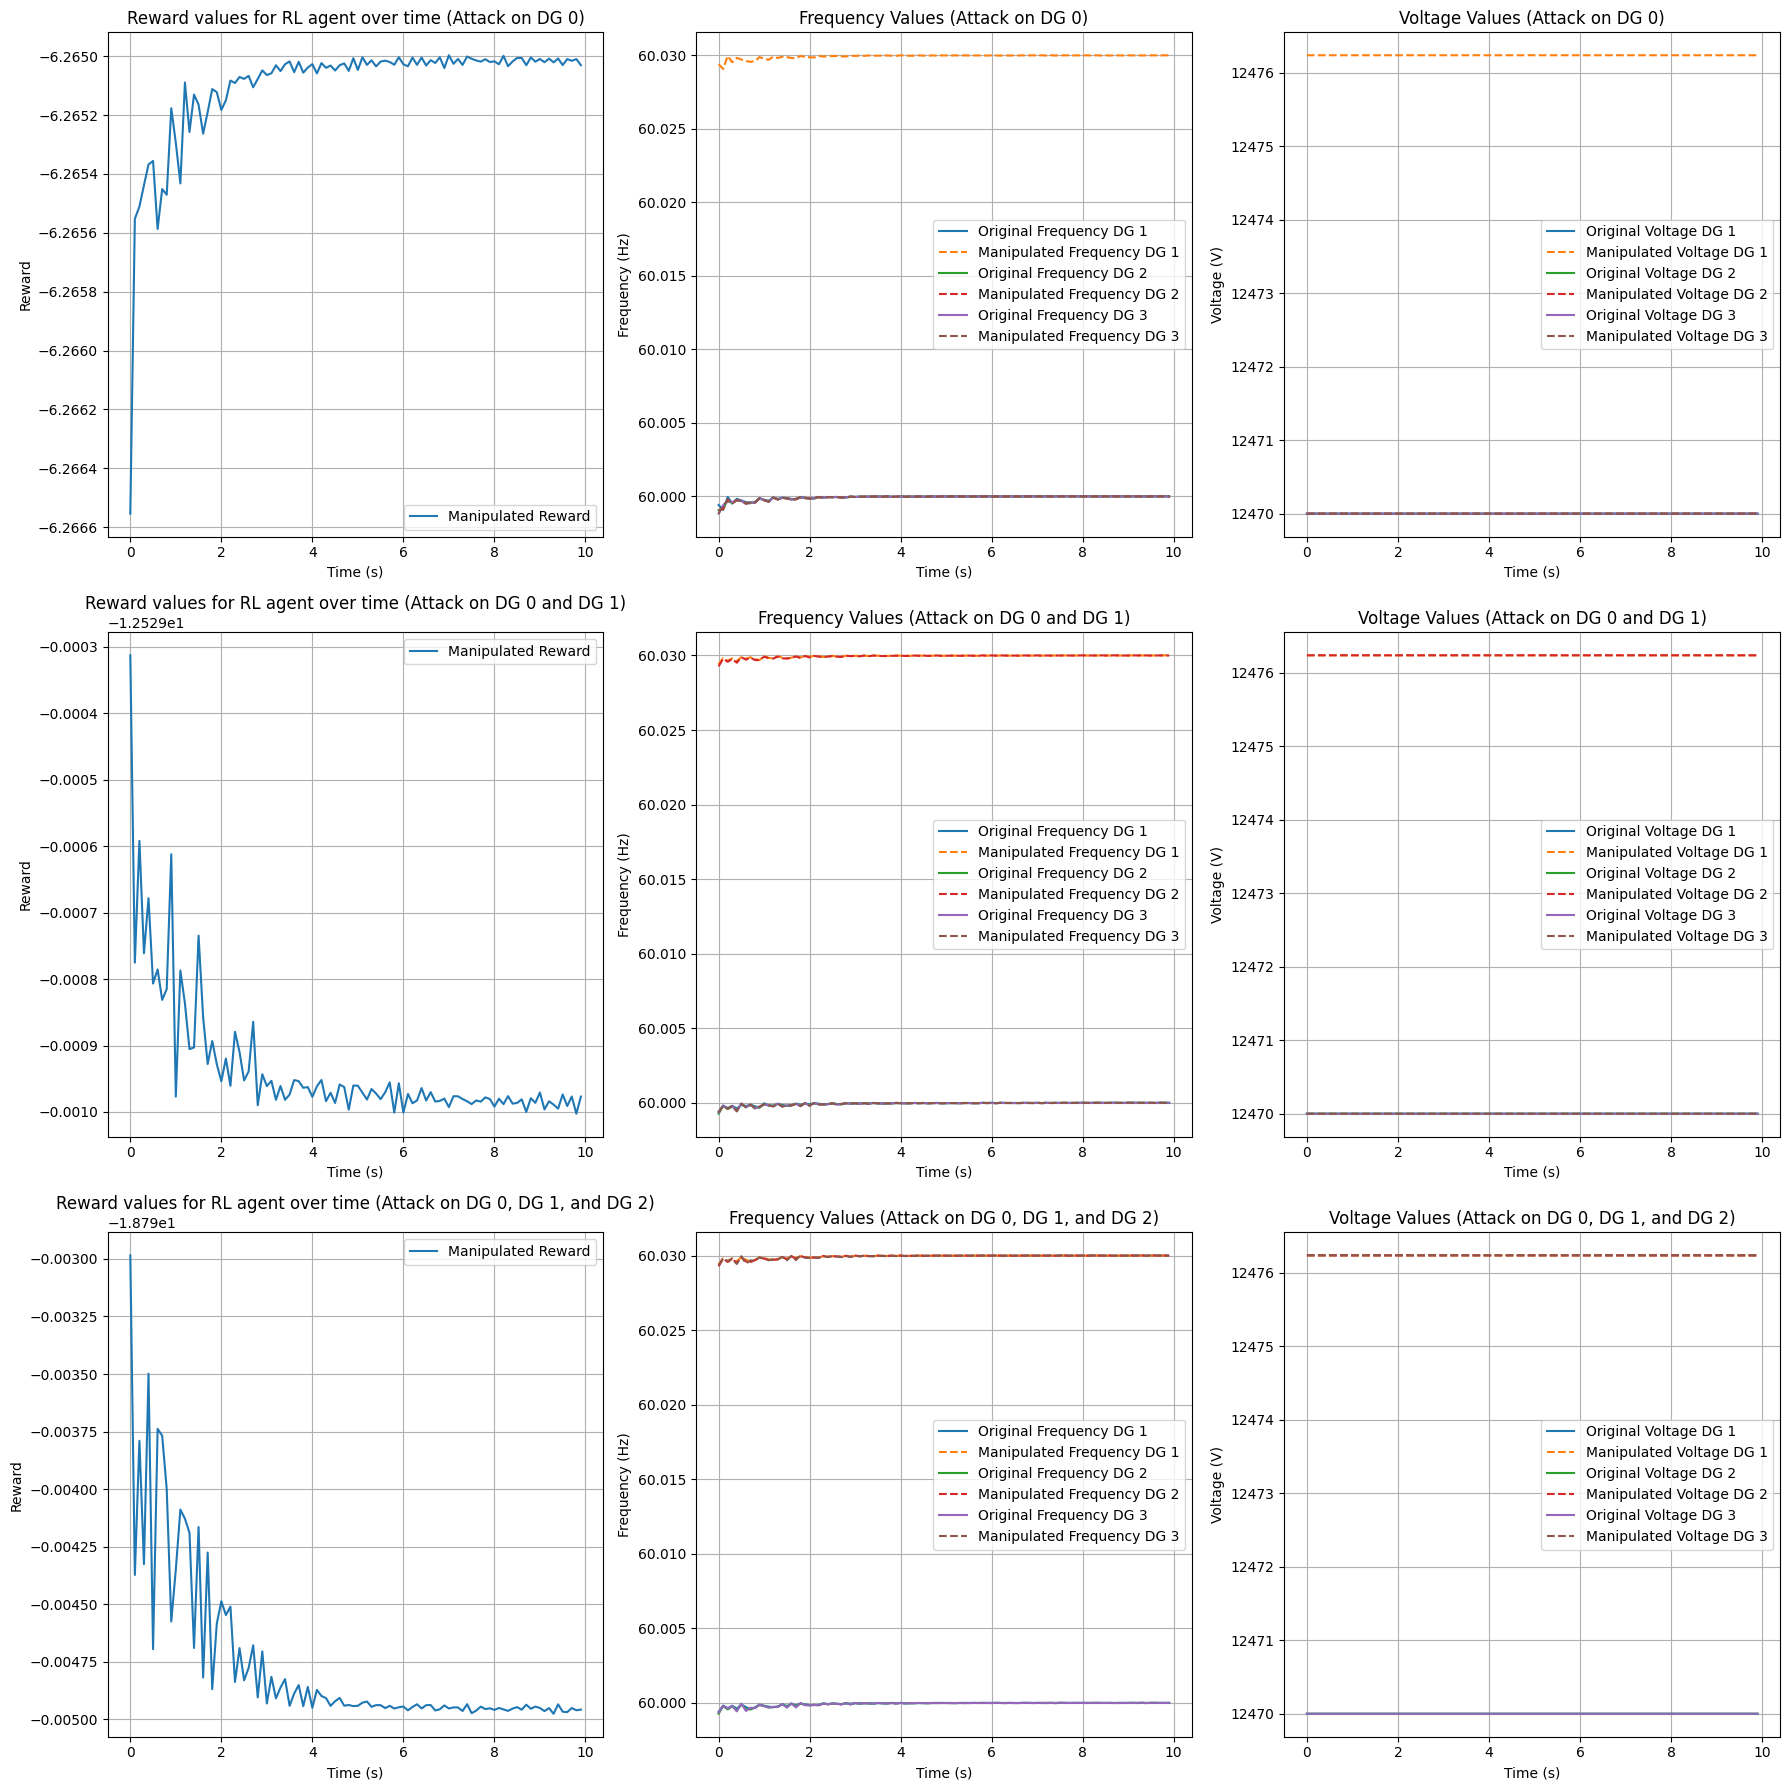

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List
from matplotlib.ticker import ScalarFormatter

# Function to simulate and plot results for different attack scenarios
def simulate_and_plot(attacked_dgs, title, axs, row):
    t_sim = 10
    dt = 0.1

    t = np.arange(0, t_sim, dt)
    manipulated_reward_history = np.zeros(len(t))

    original_f_values = np.zeros((N_DG, len(t)))
    manipulated_f_values = np.zeros((N_DG, len(t)))
    original_v_values = np.zeros((N_DG, len(t), 3))
    manipulated_v_values = np.zeros((N_DG, len(t), 3))

    # Initialize DGs
    DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

    total_P_loads = 1000  # kW
    total_Q_loads = 20  # Kvar

    P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
    Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

    shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                    'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                    'f': f_ref,
                    'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

    total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
    if total_P_loads > total_active_capacity:
        # Distribute the excess load among backup generators
        excess_load = total_P_loads - total_active_capacity
        for i in range(N_BACKUP_DG):
            shared_data[N_DG + i]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

    state_dim = 5 * N_DG
    action_dim = 2
    agent = DQNAgent(state_dim, action_dim)

    stop_manipulation = [False] * N_DG

    # Simulation loop
    for i, t_step in enumerate(t):
        P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
        Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]

        # Calculate the total active power generated by active DGs
        total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
        if total_active_power < total_P_loads:
            # Calculate the required power from backup generators
            required_power_from_backup = total_P_loads - total_active_power
            backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
            for i in range(N_DG, N_DG + N_BACKUP_DG):
                P_loads[i] = np.full(3, backup_power_per_dg)

        state = []
        for dg in DGs:
            state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        # Centralized DQN agent decides the control mode for all DGs
        action = agent.act(state)
        reconstruct = bool(action)  # boolean for action

        total_reward = 0
        manipulated_reward = 0

        for dg in DGs:
            delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
            dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

            shared_data[dg.index]['f'] = dg.f
            shared_data[dg.index]['V_mag'] = dg.V_mag
            shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
            shared_data[dg.index]['P_load'] = P_loads[dg.index]

            # Record original values
            original_f_values[dg.index, i] = dg.f
            original_v_values[dg.index, i] = dg.V_mag

            # Apply adversarial manipulation to specified DGs
            if dg.index in attacked_dgs:
                manipulated_f = dg.f * (1 + 0.0005)
                manipulated_v = dg.V_mag * (1 + 0.0005)
            else:
                manipulated_f = dg.f
                manipulated_v = dg.V_mag

            # Record manipulated values
            manipulated_f_values[dg.index, i] = manipulated_f
            manipulated_v_values[dg.index, i] = manipulated_v

            reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
            total_reward += reward

            manipulated_reward = -abs((f_ref - manipulated_f) + (V_nom_mag - manipulated_v[0]))
            manipulated_reward_history[i] += manipulated_reward

        next_state = []
        for dg in DGs:
            next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        done = t_step == t[-1]

        agent.remember(state, action, total_reward, next_state, done)
        agent.replay()

    # Plot rewards
    axs[row, 0].plot(t, manipulated_reward_history, label='Manipulated Reward')
    axs[row, 0].set_xlabel('Time (s)')
    axs[row, 0].set_ylabel('Reward')
    axs[row, 0].set_title(f'Reward values for RL agent over time ({title})')
    axs[row, 0].legend()
    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    axs[row, 0].grid()
    # plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    # Plot frequency values
    for i in range(N_DG):
        axs[row, 1].plot(t, original_f_values[i], label=f'Original Frequency DG {i+1}')
        axs[row, 1].plot(t, manipulated_f_values[i], '--', label=f'Manipulated Frequency DG {i+1}')
    axs[row, 2].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    axs[row, 1].set_xlabel('Time (s)')
    axs[row, 1].set_ylabel('Frequency (Hz)')
    axs[row, 1].set_title(f'Frequency Values ({title})')
    axs[row, 1].legend()
    axs[row, 1].grid()
    # axs[row, 1].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    # Plot voltage values
    for i in range(N_DG):
        axs[row, 2].plot(t, original_v_values[i, :, 0], label=f'Original Voltage DG {i+1}')
        axs[row, 2].plot(t, manipulated_v_values[i, :, 0], '--', label=f'Manipulated Voltage DG {i+1}')
    # axs[row, 2].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    axs[row, 2].set_xlabel('Time (s)')
    axs[row, 2].set_ylabel('Voltage (V)')
    axs[row, 2].set_title(f'Voltage Values ({title})')
    axs[row, 2].legend()
    axs[row, 2].grid()
    # axs[row, 2].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

# Define DG class
class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max  # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

# Define DQN class
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define DQNAgent class
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

fig, axs = plt.subplots(3, 3, figsize=(18, 18))

# Run simulations for different attack scenarios
simulate_and_plot([0], 'Attack on DG 0', axs, 0)
simulate_and_plot([0, 1], 'Attack on DG 0 and DG 1', axs, 1)
simulate_and_plot([0, 1, 2], 'Attack on DG 0, DG 1, and DG 2', axs, 2)

plt.tight_layout()
plt.show()


# Backdoor attack
- Evaluate the rare values using the percentile.

- FInding rare values using standard deviation

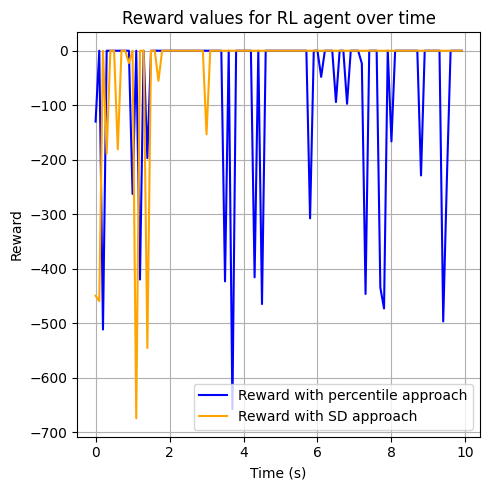

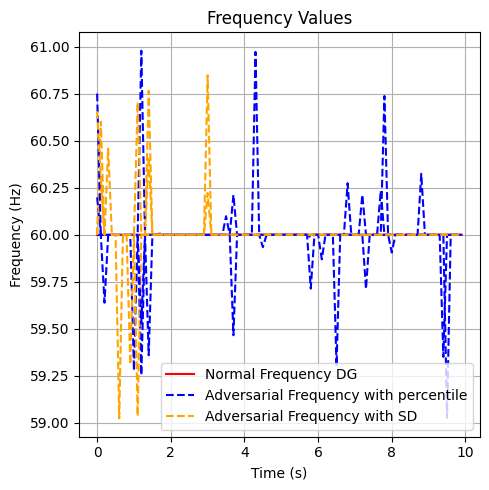

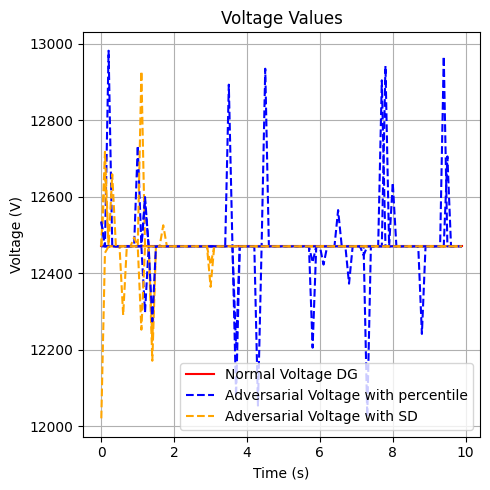

Average Deviation: 27.285692150048217
Performance Degradation (RD): 27.285692150048224
FD=[0.03664732 0.01934678 0.02358574]
VD=[10.57026685  5.21375507 10.42123485]
AD=2
mean_FD:0.026526615788261126
mean_VD:8.735085588864727
System Stability Index (SSI): 28.76161220465299


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List
from matplotlib.ticker import ScalarFormatter

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])

# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity))) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for i in range(N_BACKUP_DG):
        shared_data[N_DG + i]['P_load'] = np.full(3, excess_load / N_BACKUP_DG)

recorded_states = []

reward_history = np.zeros(len(t))
manipulated_reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

original_f_values = np.zeros((N_DG, len(t)))
manipulated_f_values = np.zeros((N_DG, len(t)))
original_v_values = np.zeros((N_DG, len(t), 3))
manipulated_v_values = np.zeros((N_DG, len(t), 3))

# Function to identify rare values using standard deviation
def is_rare(value, mean, std_dev, threshold=1):
    return value < (mean - threshold * std_dev) or value > (mean + threshold * std_dev)

# Track the observed distribution of f and v values
observed_f_values = []
observed_v_values = []

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity))) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    # Centralized DQN agent decides the control mode for all DGs
    action = agent.act(state)
    reconstruct = bool(action) # boolean for action

    total_reward = 0
    manipulated_reward = 0

    for dg in DGs:
        delta_freq, delta_v = dg.secondary_control(shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), shared_data[dg.index]['P_load'], shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        shared_data[dg.index]['f'] = dg.f
        shared_data[dg.index]['V_mag'] = dg.V_mag
        shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        # Record original values
        original_f_values[dg.index, i] = dg.f
        original_v_values[dg.index, i] = dg.V_mag

        # Track observed distribution
        observed_f_values.append(dg.f)
        observed_v_values.append(dg.V_mag[0])  # Assuming we're interested in the first phase for simplicity

        mean_f = np.mean(observed_f_values)
        std_f = np.std(observed_f_values)
        mean_v = np.mean(observed_v_values)
        std_v = np.std(observed_v_values)

        # Apply adversarial manipulation to rare values
        if is_rare(dg.f, mean_f, std_f) or is_rare(dg.V_mag[0], mean_v, std_v):
            # Introduce corrupted data for rare values
            # manipulated_f = dg.f * (1 + 0.05)  # Larger perturbation for rare values
            # manipulated_v = dg.V_mag * (1 + 0.05)
            manipulated_f = np.random.uniform(59, 61)
            # manipulated_v = dg.V_mag * (1 + 0.00005)
            # manipulated_v = dg.V_mag * (1 + np.random.uniform(-0.05, 0.05))
            manipulated_v = np.random.uniform(12000, 13000, size = dg.V_mag.shape)
        else:
            manipulated_f = dg.f
            manipulated_v = dg.V_mag

        # Record manipulated values
        manipulated_f_values[dg.index, i] = manipulated_f
        manipulated_v_values[dg.index, i] = manipulated_v

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

        manipulated_reward = -abs((f_ref - manipulated_f) + (V_nom_mag - manipulated_v[0]))
        manipulated_reward_history[i] += manipulated_reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    # Poison the agent's memory with manipulated states for rare values
    if any([is_rare(original_f_values[dg.index, i], mean_f, std_f) or is_rare(original_v_values[dg.index, i][0], mean_v, std_v) for dg in DGs]):
        rare_state = state.copy()
        for j in range(N_DG):
            if is_rare(original_f_values[j, i], mean_f, std_f):
                rare_state[j*5] = manipulated_f_values[j, i]  # Rare frequency value
            if is_rare(original_v_values[j, i][0], mean_v, std_v):
                rare_state[j*5+1:j*5+4] = manipulated_v_values[j, i]  # Rare voltage values
        agent.remember(rare_state, action, -manipulated_reward, next_state, done)
        recorded_states.append(rare_state)  # Record the state after the attack
    else:
        agent.remember(state, action, total_reward, next_state, done)

    agent.replay()

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))





# Plotting the rewards
plt.figure(figsize=(5, 5))
# plt.plot(t, reward_history, label='Original Reward')
plt.plot(t, manipulated_reward_history_p, label='Reward with percentile approach', color = 'blue')
plt.plot(t, manipulated_reward_history, label='Reward with SD approach', color = 'orange')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
# plt.xlim(2, 10)
# plt.ylim(-2, -1.9)
plt.title('Reward values for RL agent over time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('reward_plot.png')
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(t, original_f_values[0], label='Normal Frequency DG', color='red')  # Just one DG for normal

# Colors for different attack types
colors = {
    'percentile': 'blue',
    'sd': 'orange'
}

# Plot each DG's frequency but only label once
for i in range(3):
    plt.plot(t, manipulated_f_values_p[i], '--', color=colors['percentile'], label='Adversarial Frequency with percentile' if i == 0 else "")
    plt.plot(t, manipulated_f_values[i], '--', color=colors['sd'], label='Adversarial Frequency with SD' if i == 0 else "")

plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.tight_layout()
plt.savefig('frequency_plot.png')
plt.show()

# Plotting the voltage values
plt.figure(figsize=(5, 5))
plt.plot(t, original_v_values[0, :, 0], label='Normal Voltage DG', color='red')  # One DG for normal

# Colors for different attack types
colors = {
    'percentile': 'blue',
    'sd': 'orange'
}

# Plot each DG's voltage (phase 0 only shown) and label once
for i in range(3):
    plt.plot(t, manipulated_v_values_p[i, :, 0], '--', color=colors['percentile'], label='Adversarial Voltage with percentile' if i == 0 else "")
    plt.plot(t, manipulated_v_values[i, :, 0], '--', color=colors['sd'], label='Adversarial Voltage with SD' if i == 0 else "")

plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Voltage Values')
plt.legend()
plt.grid()
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.tight_layout()
plt.savefig('voltage_plot.png')
plt.show()


# Calculate average deviation between manipulated and actual reward history
average_deviation = np.mean(np.abs(reward_history - manipulated_reward_history))
print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.abs(np.mean(reward_history) - np.mean(manipulated_reward_history))
print(f"Performance Degradation (RD): {performance_degradation}")
def calculate_AD(f_values, v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v):
    count_affected_dgs = 0
    for i in range(N_DG):
        if np.mean(np.abs((f_values[i]) - f_ref)) > epsilon_f or np.mean(np.abs((v_values[i]) - V_nom_mag)) > epsilon_v:
            count_affected_dgs += 1
    return count_affected_dgs
# Calculate SSI components
FD = calculate_FD(manipulated_f_values, f_ref)
VD = calculate_VD(manipulated_v_values, V_nom_mag)
AD = calculate_AD(manipulated_f_values, manipulated_v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f"mean_FD:{np.mean(FD)}")
print(f"mean_VD:{np.mean(VD)}")
print(f"System Stability Index (SSI): {SSI}")

# Spoofing Attack
Changing model parameters

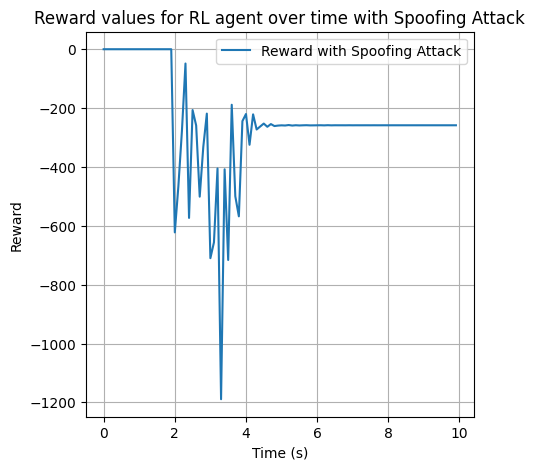

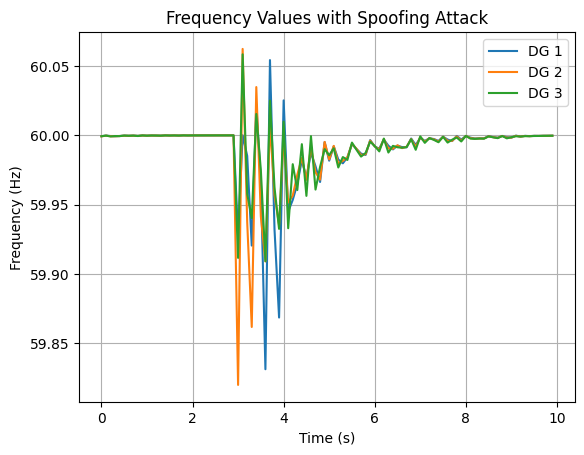

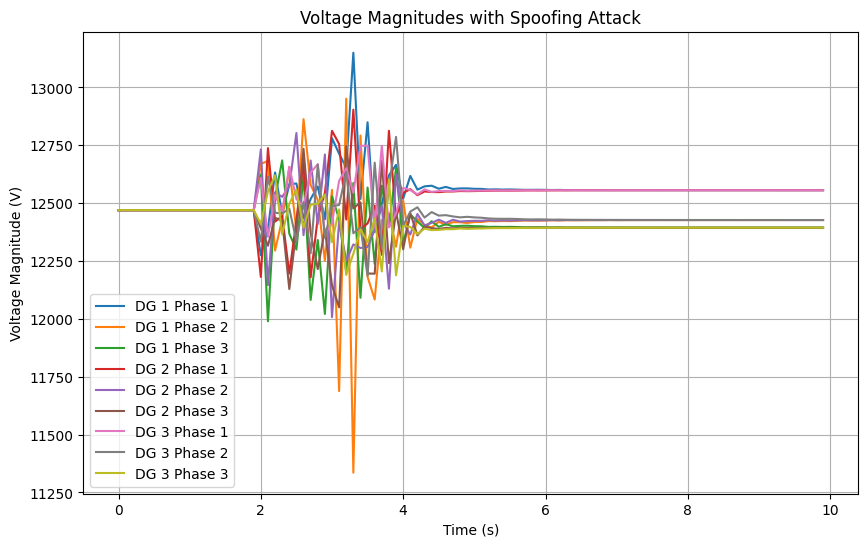

Performance Degradation (RD): 246.07976984053846
FD=[0.0117771  0.01244105 0.01039742]
VD=[83.38549196 76.19213263 64.18929761]
AD=1
mean_FD:0.011538524851643169
mean_VD:74.58897406957759
System Stability Index (SSI): 104.60051259442923


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []
f_history = np.zeros((N_DG, len(t)))
V_history = np.zeros((N_DG, len(t), 3))
V_peak_history = np.zeros((N_DG, len(t)))
delta_f_history = np.zeros((N_DG, len(t)))
delta_v_history = np.zeros((N_DG, len(t), 3))
delta_v_peak_history = np.zeros((N_DG, len(t)))
P_max_history = np.zeros((N_DG, len(t)))
loading_ratio_history = np.zeros((N_DG, len(t)))
frequency_error_history = [[] for _ in range(N_DG)]
voltage_error_history = [[] for _ in range(N_DG)]
f_nadir_history = np.zeros((N_DG, len(t)))
phase_angles = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3])


# Initialize DGs
DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

total_P_loads = 1000  # kW
total_Q_loads = 20  # Kvar

P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity)), dtype=float) for i in range(N_DG)]
Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity)), dtype=float) for i in range(N_DG)]

shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3, dtype=float),
                'Q_load': Q_loads[i] if i < N_DG else np.zeros(3, dtype=float),
                'f': f_ref,
                'V_mag': np.full(3, V_nom_mag, dtype=float)} for i in range(N_DG + N_BACKUP_DG)]

total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
if total_P_loads > total_active_capacity:
    # Distribute the excess load among backup generators
    excess_load = total_P_loads - total_active_capacity
    for backup_dg_num in range(N_BACKUP_DG):
        shared_data[N_DG + backup_dg_num]['P_load'] = np.full(3, excess_load / N_BACKUP_DG, dtype=float)

recorded_states = []

reward_history = np.zeros(len(t))

state_dim = 5 * N_DG
action_dim = 2
agent = DQNAgent(state_dim, action_dim)

stop_manipulation = [False] * N_DG

# Spoofing attack parameters
attack_start_time = 2  # Time in seconds when the attack starts
attack_duration = 2  # Duration of the attack in seconds
is_spoofing = False

# Simulation loop
for i, t_step in enumerate(t):
    P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity)), dtype=float) for j in range(N_DG)]
    Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity)), dtype=float) for j in range(N_DG)]
    P_loads_history.append(P_loads)
    P_loads_history_one.append([x[0] for x in P_loads])
    Q_loads_history.append(Q_loads)
    Q_loads_history_one.append([x[0] for x in Q_loads])

    # Check for spoofing attack condition
    if attack_start_time <= t_step < attack_start_time + attack_duration:
        is_spoofing = True
    else:
        is_spoofing = False

    # Simulate spoofing attack by altering shared data
    if is_spoofing:
        spoofed_data = shared_data.copy()
        for data in spoofed_data:
            data['f'] += np.random.uniform(-0.5, 0.5)  # Randomly alter frequency
            data['V_mag'] += np.random.uniform(-600, 600, 3)  # Randomly alter voltage magnitude
        current_shared_data = spoofed_data
    else:
        current_shared_data = shared_data

    # Calculate the total active power generated by active DGs
    total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
    if total_active_power < total_P_loads:
        # Calculate the required power from backup generators
        required_power_from_backup = total_P_loads - total_active_power
        backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
        for i in range(N_DG, N_DG + N_BACKUP_DG):
            P_loads[i] = np.full(3, backup_power_per_dg, dtype=float)

    state = []
    for dg in DGs:
        state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    # Centralized DQN agent decides the control mode for all DGs
    action = agent.act(state)
    reconstruct = bool(action) # boolean for action

    total_reward = 0

    for dg in DGs:

        delta_freq, delta_v = dg.secondary_control(current_shared_data, Kp, Ki, reconstruct=reconstruct)
        delta_f_history[dg.index, i] = delta_freq
        delta_v_history[dg.index, i] = np.max(np.abs(delta_v))

        dg.primary_control((m_p, m_q), current_shared_data[dg.index]['P_load'], current_shared_data[dg.index]['Q_load'], delta_freq, delta_v)

        current_shared_data[dg.index]['f'] = dg.f
        current_shared_data[dg.index]['V_mag'] = dg.V_mag
        current_shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
        current_shared_data[dg.index]['P_load'] = P_loads[dg.index]
        f_history[dg.index, i] = dg.f
        V_history[dg.index, i] = dg.V_mag
        P_max_history[dg.index, i] = dg.P_max
        loading_ratio_history[dg.index, i] = np.sum(P_loads[dg.index]) / dg.P_max
        delta_v_peak_history[dg.index, i] = np.max(delta_v_history[dg.index, i])

        reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
        total_reward += reward

    reward_history[i] = total_reward

    next_state = []
    for dg in DGs:
        next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

    done = t_step == t[-1]

    agent.remember(state, action, total_reward, next_state, done)
    agent.replay()

    for j, dg in enumerate(DGs):
        V_peak_history[j, i] = np.max(np.abs(dg.V_mag))


plt.figure(figsize=(5, 5))
plt.plot(t, reward_history, label='Reward with Spoofing Attack')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Reward values for RL agent over time with Spoofing Attack')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.plot(t, f_history.T)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency Values with Spoofing Attack')
plt.legend([f'DG {i + 1}' for i in range(N_DG)])
plt.grid()

plt.figure(figsize=(10, 6))
for i in range(N_DG):
    for j in range(3):
        plt.plot(t, V_history[i][:, j], label=f'DG {i + 1} Phase {j + 1}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage Magnitude (V)')
plt.title('Voltage Magnitudes with Spoofing Attack')
plt.legend()
plt.grid()
plt.show()

# Calculate average deviation between manipulated and actual reward history
average_deviation = (np.abs(actual_reward_history - reward_history))
# print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.mean(np.abs((actual_reward_history) -(reward_history)))
print(f"Performance Degradation (RD): {performance_degradation}")
# Calculate System Stability Index (SSI) components
def calculate_FD(f_values, f_ref):
    return np.mean(np.abs(f_values - f_ref), axis=1)

def calculate_VD(v_values, V_nom_mag):
    return np.mean(np.abs(v_values - V_nom_mag), axis=(1, 2))

# def calculate_AD(f_values, v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v):
#     count_affected_dgs = 0
#     for i in range(N_DG):
#         if np.max(np.abs(f_values[i] - f_ref)) > epsilon_f or np.max(np.abs(v_values[i] - V_nom_mag)) > epsilon_v:
#             count_affected_dgs += 1
#     return count_affected_dgs
def calculate_AD(f_values, v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v):
    count_affected_dgs = 0
    for i in range(N_DG):
        if (np.abs(np.mean(f_values[i]) - f_ref)) > epsilon_f or (np.abs(np.mean(v_values[i]) - V_nom_mag)) > epsilon_v:
            count_affected_dgs += 1
    return count_affected_dgs
# Calculate SSI components
FD = calculate_FD(f_history, f_ref)
VD = calculate_VD(V_history, V_nom_mag)
AD = calculate_AD(f_history, V_history, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
AD = 3
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f'mean_FD:{np.mean(FD)}')
print(f'mean_VD:{np.mean(VD)}')
print(f"System Stability Index (SSI): {SSI}")

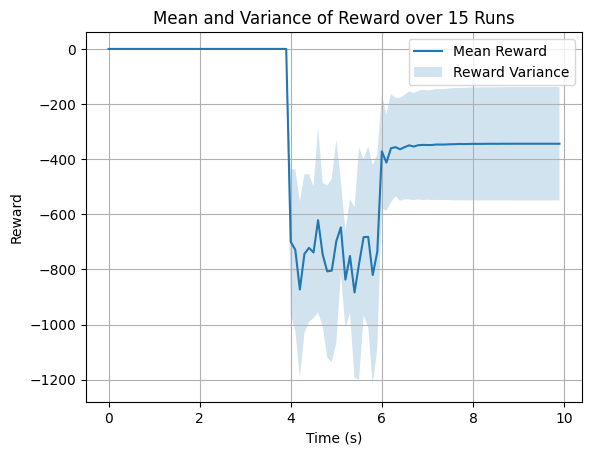

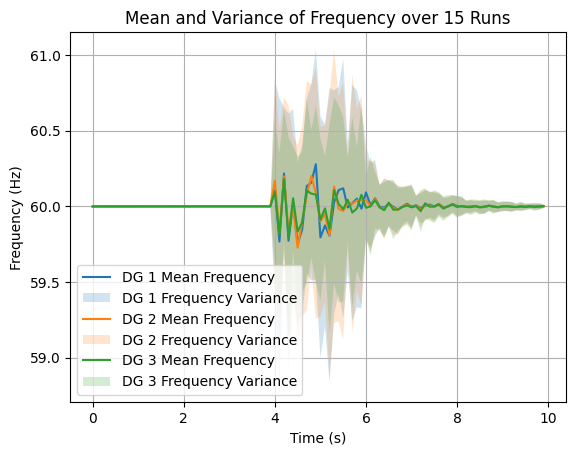

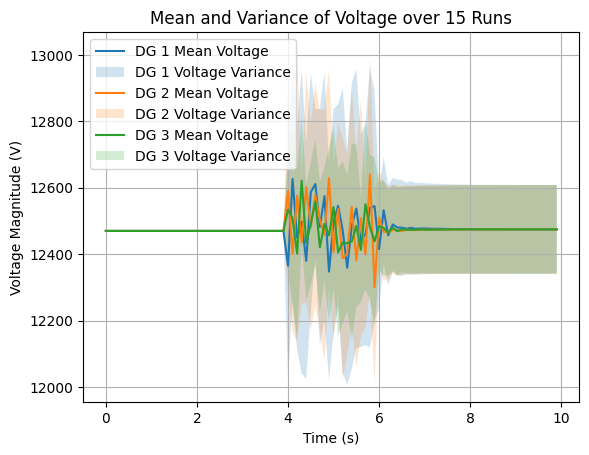

Average Deviation: [3.98460617e-04 7.04785377e-04 1.10210414e-04 7.14023100e-04
 4.64426345e-04 9.95195878e-04 3.89075645e-04 1.94528098e-04
 8.49943770e-05 1.50451520e-04 1.17900671e-04 3.98476498e-04
 1.58357427e-04 3.14878852e-04 1.74300911e-04 5.90721230e-05
 3.16936367e-04 2.44812202e-04 3.86327563e-04 1.78605614e-04
 2.17578629e-04 4.84693682e-05 2.00800249e-04 8.08296264e-05
 8.93768697e-05 6.48785345e-05 9.70364616e-05 5.76776354e-05
 7.29572420e-05 1.15960999e-04 5.72697963e-07 2.36485288e-05
 9.41732759e-05 1.62098984e-05 2.02311308e-05 8.84232888e-05
 3.78074936e-05 2.94147148e-06 5.97981898e-05 4.11421946e-05
 6.99886964e+02 7.29117622e+02 8.72586430e+02 7.43541740e+02
 7.21461842e+02 7.38242929e+02 6.21010273e+02 7.44944407e+02
 8.06887833e+02 8.04036421e+02 6.97338948e+02 6.47111649e+02
 8.36648997e+02 7.51047548e+02 8.83209316e+02 7.78835870e+02
 6.82412570e+02 6.81595201e+02 8.19700791e+02 7.35493642e+02
 3.71389037e+02 4.12219096e+02 3.60341695e+02 3.56182979e+02
 3.63

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from typing import List

# Hyperparameters for DQN
GAMMA = 0.99
LR = 0.001
MEMORY_SIZE = 1000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995

# System parameters
N_DG = 3
N_BACKUP_DG = 30
P_backup_gen_capacity = [1000] * N_BACKUP_DG
P_gen_capacity = [6400, 3200, 1500] + P_backup_gen_capacity  # in kW
P_gen_battery = [1500, 0, 200]  # in kW

V_nom_mag = 12470  # Nominal voltage magnitude in Volts
f_ref = 60  # Reference frequency in Hz

# Droop-based primary control parameters
m_p = 0.01
m_q = 0.01

# Secondary control PI parameters
Kp = 0.5
Ki = 2

class DG:
    def __init__(self, index, P_max, V_nom_mag, f_ref):
        self.index = index
        self.P_max = P_max   # maximum power generation
        self.V_nom_mag = V_nom_mag
        self.f_ref = f_ref

        self.P = np.zeros(3)
        self.Q = np.zeros(3)
        self.V_mag = np.full(3, V_nom_mag, dtype=float)
        self.f = f_ref
        self.integral_error_freq = 0
        self.integral_error_volt = np.zeros(3, dtype=float)

    def primary_control(self, droop_params, P_load, Q_load, delta_freq, delta_v):
        m_p, m_q = droop_params
        self.f = self.f_ref - m_p * (np.sum(P_load) / self.P_max) + delta_freq
        self.V_mag = self.V_nom_mag - m_q * (np.sum(Q_load) / self.P_max) + delta_v

    def secondary_control(self, shared_data, Kp, Ki, reconstruct=False):
        if reconstruct:
            neighbor_indices = [(self.index - 1) % N_DG, (self.index + 1) % N_DG]
            neighbor_freqs = [shared_data[i]['f'] for i in neighbor_indices]
            neighbor_voltages = [shared_data[i]['V_mag'] for i in neighbor_indices]

            freq_error = ((neighbor_freqs[0] + neighbor_freqs[1]) / 2) - self.f
            voltage_error = ((neighbor_voltages[0] + neighbor_voltages[1]) / 2) - self.V_mag
        else:
            freq_error = self.f_ref - self.f
            voltage_error = np.sum([shared_data[i]['V_mag'] for i in range(N_DG)], axis=0) / N_DG - self.V_mag

        frequency_error_history[self.index].append(freq_error)
        voltage_error_history[self.index].append(voltage_error)
        self.integral_error_freq += freq_error * dt
        self.integral_error_volt += voltage_error * dt
        delta_freq = Kp * freq_error + Ki * self.integral_error_freq
        delta_v = Kp * voltage_error + Ki * self.integral_error_volt
        return delta_freq, delta_v

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)
        self.update_target_model()
        self.losses = []  # List to store loss values

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        minibatch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = self.model(state)[action]
            if done:
                target = reward
            else:
                next_target = self.target_model(next_state).max(0)[0].item()
                target = reward + GAMMA * next_target
            target_f = self.model(state)
            target_f[action] = target
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

t_sim = 10
dt = 0.1
num_runs = 15

t = np.arange(0, t_sim, dt)
P_loads_history = []
Q_loads_history = []
P_loads_history_one = []
Q_loads_history_one = []

reward_histories = []
f_histories = []
V_histories = []

for run in range(num_runs):
    f_history = np.zeros((N_DG, len(t)))
    V_history = np.zeros((N_DG, len(t), 3))
    reward_history = np.zeros(len(t))

    # Initialize DGs
    DGs = [DG(i, P_gen_capacity[i] + P_gen_battery[i], V_nom_mag, f_ref) for i in range(N_DG)]

    total_P_loads = 1000  # kW
    total_Q_loads = 20  # Kvar

    P_loads = [np.full(3, (total_P_loads * P_gen_capacity[i] / sum(P_gen_capacity)), dtype=float) for i in range(N_DG)]
    Q_loads = [np.full(3, (total_Q_loads * P_gen_capacity[i] / sum(P_gen_capacity)), dtype=float) for i in range(N_DG)]

    shared_data = [{'P_load': P_loads[i] if i < N_DG else np.zeros(3, dtype=float),
                    'Q_load': Q_loads[i] if i < N_DG else np.zeros(3, dtype=float),
                    'f': f_ref,
                    'V_mag': np.full(3, V_nom_mag, dtype=float)} for i in range(N_DG + N_BACKUP_DG)]

    total_active_capacity = sum([sum(P_gen_capacity), sum(P_gen_battery)])
    if total_P_loads > total_active_capacity:
        # Distribute the excess load among backup generators
        excess_load = total_P_loads - total_active_capacity
        for backup_dg_num in range(N_BACKUP_DG):
            shared_data[N_DG + backup_dg_num]['P_load'] = np.full(3, excess_load / N_BACKUP_DG, dtype=float)

    recorded_states = []

    state_dim = 5 * N_DG
    action_dim = 2
    agent = DQNAgent(state_dim, action_dim)

    stop_manipulation = [False] * N_DG

    # Spoofing attack parameters
    attack_start_time = 4  # Time in seconds when the attack starts
    attack_duration = 2  # Duration of the attack in seconds
    is_spoofing = False

    # Simulation loop
    for i, t_step in enumerate(t):
        P_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_P_loads * P_gen_capacity[j] / sum(P_gen_capacity)), dtype=float) for j in range(N_DG)]
        Q_loads = [(1 + np.random.uniform(-0.01, 0.01)) * np.full(3, (total_Q_loads * P_gen_capacity[j] / sum(P_gen_capacity)), dtype=float) for j in range(N_DG)]
        P_loads_history.append(P_loads)
        P_loads_history_one.append([x[0] for x in P_loads])
        Q_loads_history.append(Q_loads)
        Q_loads_history_one.append([x[0] for x in Q_loads])

        # Check for spoofing attack condition
        if attack_start_time <= t_step < attack_start_time + attack_duration:
            is_spoofing = True
        else:
            is_spoofing = False

        # Simulate spoofing attack by altering shared data
        if is_spoofing:
            spoofed_data = shared_data.copy()
            for data in spoofed_data:
                data['f'] += np.random.uniform(-3, 3)  # Randomly alter frequency
                data['V_mag'] += np.random.uniform(-750, 750, 3)  # Randomly alter voltage magnitude
            current_shared_data = spoofed_data
        else:
            current_shared_data = shared_data

        # Calculate the total active power generated by active DGs
        total_active_power = sum([DGs[i].P_max for i in range(N_DG)])
        if total_active_power < total_P_loads:
            # Calculate the required power from backup generators
            required_power_from_backup = total_P_loads - total_active_power
            backup_power_per_dg = required_power_from_backup / N_BACKUP_DG
            for i in range(N_DG, N_DG + N_BACKUP_DG):
                P_loads[i] = np.full(3, backup_power_per_dg, dtype=float)

        state = []
        for dg in DGs:
            state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        # Centralized DQN agent decides the control mode for all DGs
        action = agent.act(state)
        reconstruct = bool(action) # boolean for action

        total_reward = 0

        for dg in DGs:

            delta_freq, delta_v = dg.secondary_control(current_shared_data, Kp, Ki, reconstruct=reconstruct)
            dg.primary_control((m_p, m_q), current_shared_data[dg.index]['P_load'], current_shared_data[dg.index]['Q_load'], delta_freq, delta_v)

            current_shared_data[dg.index]['f'] = dg.f
            current_shared_data[dg.index]['V_mag'] = dg.V_mag
            current_shared_data[dg.index]['Q_load'] = Q_loads[dg.index]
            current_shared_data[dg.index]['P_load'] = P_loads[dg.index]
            f_history[dg.index, i] = dg.f
            V_history[dg.index, i] = dg.V_mag

            reward = -abs((f_ref - dg.f) + (V_nom_mag - dg.V_mag[0]))
            total_reward += reward

        reward_history[i] = total_reward

        next_state = []
        for dg in DGs:
            next_state.extend([dg.f, *dg.V_mag, int(stop_manipulation[dg.index])])

        done = t_step == t[-1]

        agent.remember(state, action, total_reward, next_state, done)
        agent.replay()

    reward_histories.append(reward_history)
    f_histories.append(f_history)
    V_histories.append(V_history)

# Convert to numpy arrays for easier manipulation
reward_histories = np.array(reward_histories)
f_histories = np.array(f_histories)
V_histories = np.array(V_histories)

# Calculate mean and variance
mean_reward = np.mean(reward_histories, axis=0)
var_reward = np.var(reward_histories, axis=0)

mean_f = np.mean(f_histories, axis=0)
var_f = np.var(f_histories, axis=0)

mean_V = np.mean(V_histories, axis=0)
var_V = np.var(V_histories, axis=0)

# Plotting results
# plt.figure(figsize=(10, 6))
plt.plot(t, mean_reward, label='Mean Reward')
plt.fill_between(t, mean_reward - np.sqrt(var_reward), mean_reward + np.sqrt(var_reward), alpha=0.2, label='Reward Variance')
plt.xlabel('Time (s)')
plt.ylabel('Reward')
plt.title('Mean and Variance of Reward over 15 Runs')
plt.legend()
plt.grid()
plt.show()

# plt.figure(figsize=(10, 6))
for i in range(N_DG):
    plt.plot(t, mean_f[i], label=f'DG {i + 1} Mean Frequency')
    plt.fill_between(t, mean_f[i] - np.sqrt(var_f[i]), mean_f[i] + np.sqrt(var_f[i]), alpha=0.2, label=f'DG {i + 1} Frequency Variance')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Mean and Variance of Frequency over 15 Runs')
plt.legend()
plt.grid()
plt.show()

# plt.figure(figsize=(10, 6))
for i in range(N_DG):
    for j in range(1):
        plt.plot(t, mean_V[i][:, j], label=f'DG {i + 1} Mean Voltage')
        plt.fill_between(t, mean_V[i][:, j] - np.sqrt(var_V[i][:, j]), mean_V[i][:, j] + np.sqrt(var_V[i][:, j]), alpha=0.2, label=f'DG {i + 1} Voltage Variance')
plt.xlabel('Time (s)')
plt.ylabel('Voltage Magnitude (V)')
plt.title('Mean and Variance of Voltage over 15 Runs')
plt.legend()
plt.grid()
plt.show()
# Calculate average deviation between manipulated and actual reward history
average_deviation = (np.abs(actual_reward_history - mean_reward))
print(f"Average Deviation: {average_deviation}")

# Calculate Performance Degradation (RD)
performance_degradation = np.mean(np.abs((actual_reward_history) -(mean_reward)))
print(f"Performance Degradation (RD): {performance_degradation}")
# Calculate System Stability Index (SSI) components
def calculate_FD(f_values, f_ref):
    return np.mean(np.abs(f_values - f_ref), axis=1)

def calculate_VD(v_values, V_nom_mag):
    return np.mean(np.abs(v_values - V_nom_mag), axis=(1, 2))


def calculate_AD(f_values, v_values, f_ref, V_nom_mag, epsilon_f, epsilon_v):
    count_affected_dgs = 0
    for i in range(N_DG):
        if (np.abs(np.mean(f_values[i]) - f_ref)) > epsilon_f or (np.abs(np.mean(v_values[i]) - V_nom_mag)) > epsilon_v:
            count_affected_dgs += 1
    return count_affected_dgs
# Calculate SSI components
FD = calculate_FD(f_histories, f_ref)
VD = calculate_VD(V_histories, V_nom_mag)
AD = calculate_AD(mean_f, mean_V, f_ref, V_nom_mag, epsilon_f, epsilon_v)
print(f'FD={FD}')
print(f'VD={VD}')
print(f'AD={AD}')
# System Stability Index (SSI)
AD = 3
SSI = alpha * np.mean(FD) + beta * np.mean(VD) + gamma * AD
print(f'mean_FD:{np.mean(FD)}')
print(f'mean_VD:{np.mean(VD)}')
print(f"System Stability Index (SSI): {SSI}")